In [32]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import numpy as np

def function_tel_tomography(n=0, shots=1000):
    # Registradores quânticos
    Alice = QuantumRegister(1, 'Alice')
    Bob = QuantumRegister(1, 'Bob')
    Secret = QuantumRegister(1, 'Secret')
    c = ClassicalRegister(3, 'c')  # c[0] = Secret, c[1] = Alice, c[2] = tomografia

    if n > 0:
        ext = QuantumRegister(n, 'ext')
        circuit = QuantumCircuit(Secret, Alice, Bob, ext, c)
    else:
        circuit = QuantumCircuit(Secret, Alice, Bob, c)

    # EPR
    circuit.h(Alice)
    circuit.cx(Alice, Bob)
    circuit.barrier()

    # Swaps
    if n > 0:
        circuit.swap(Bob[0], ext[0])
        for i in range(1, n):
            circuit.swap(ext[i - 1], ext[i])
        final_target = ext[n - 1]
    else:
        final_target = Bob[0]

    # Estado secreto: H|0> = |+>
    circuit.barrier()
    circuit.h(Secret)
    circuit.barrier()

    # Entrelançamento e medições
    circuit.cx(Secret, Alice)
    circuit.h(Secret)
    circuit.barrier()

    circuit.measure(Alice, c[0])
    circuit.measure(Secret, c[1])
    circuit.barrier()

    # Correções condicionais baseadas nas medições
    with circuit.if_test((c, 1)):
        circuit.x(Bob)
    with circuit.if_test((c, 2)):
        circuit.z(Bob)

    # =============== TOMOGRAFIA DIRETA ===============
    backend = AerSimulator()
    pauli_list = [
        np.eye(2),
        np.array([[0.0, 1.0], [1.0, 0.0]]),       # X
        np.array([[0, -1.0j], [1.0j, 0.0]]),      # Y
        np.array([[1.0, 0.0], [0.0, -1.0]])       # Z
    ]
    expectation_values = {}

    for base in ['X', 'Y', 'Z']:
        circ = circuit.copy()

        # Aplica a rotação de base antes da medição
        if base == 'X':
            circ.h(Bob)
        elif base == 'Y':
            circ.sdg(Bob)
            circ.h(Bob)

        # Mede o qubit final no registrador c[2]
        circ.measure(Bob, c[2])

        transpiled = transpile(circ, backend)
        result = backend.run(transpiled, shots=shots).result()
        counts = result.get_counts()

        p0 = sum(c for b, c in counts.items() if b[0] == '0')
        p1 = sum(c for b, c in counts.items() if b[0] == '1')
        total = p0 + p1 or 1
        expectation_values[base] = (p0 - p1) / total

    # Reconstrução da matriz densidade
    rho = 0.5 * (
        pauli_list[0]
        + expectation_values['X'] * pauli_list[1]
        + expectation_values['Y'] * pauli_list[2]
        + expectation_values['Z'] * pauli_list[3]
    )

    return rho, expectation_values, circuit


In [33]:
rho, exps, circ = function_tel_tomography(n=0,shots=100000)
print("Matriz densidade reconstruída:")
print(rho)

print("Valores esperados:")
print(exps)


Matriz densidade reconstruída:
[[0.49788+0.j      0.25093-0.00106j]
 [0.25093+0.00106j 0.50212+0.j     ]]
Valores esperados:
{'X': 0.50186, 'Y': 0.00212, 'Z': -0.00424}


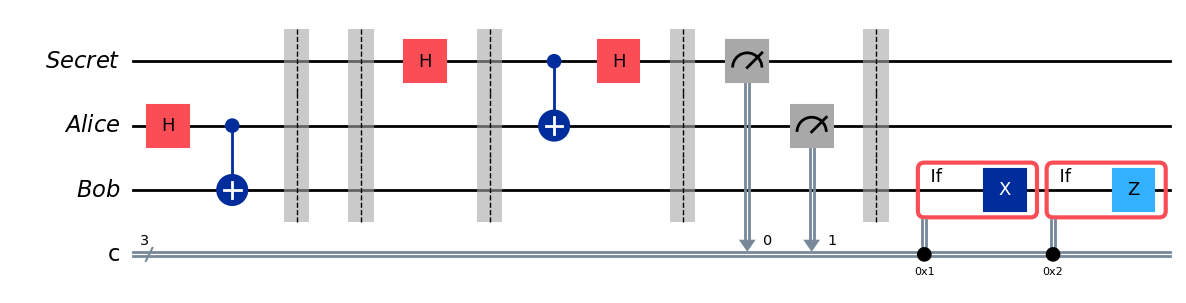

In [28]:
circ.draw('mpl')